In [146]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math as mt
import pandas as pd
import xgboost
import lightgbm
#import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.metrics import (r2_score, roc_auc_score, roc_curve, accuracy_score, f1_score,
                             mean_squared_error, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [70]:
import os
os.environ["R_HOME"] = r"C:\R\R-4.2.1" # the path to R
import rpy2

In [71]:
%load_ext rpy2.ipython

C:\Users\vauli\AppData\Local\Programs\Python\Python311\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [72]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

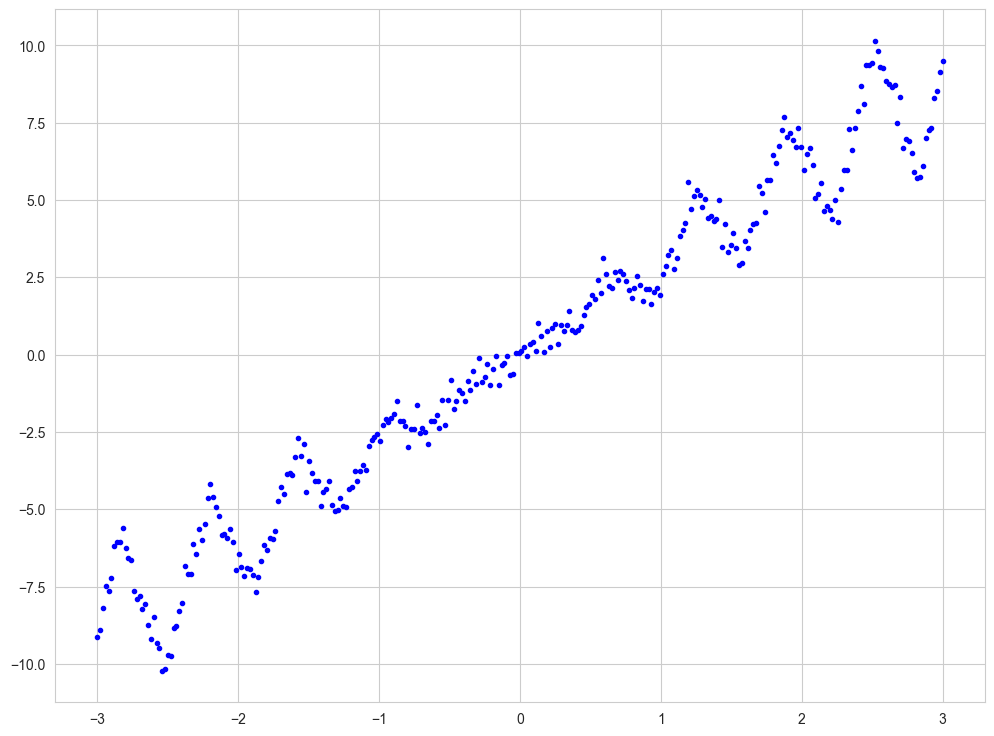

In [5]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [6]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", i=0):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    #plt.set_prop_cycle(color=bi_pride(np.linspace(0,1,10)))
    cmap = plt.get_cmap('cool')
    colors = cmap(np.linspace(0,1,20))
    plt.plot(x1, y_pred, linewidth=2, alpha=0.5, c=colors[i], label=r"$\hat{y}$"+f'\tmax_depth={i}')
    plt.legend()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

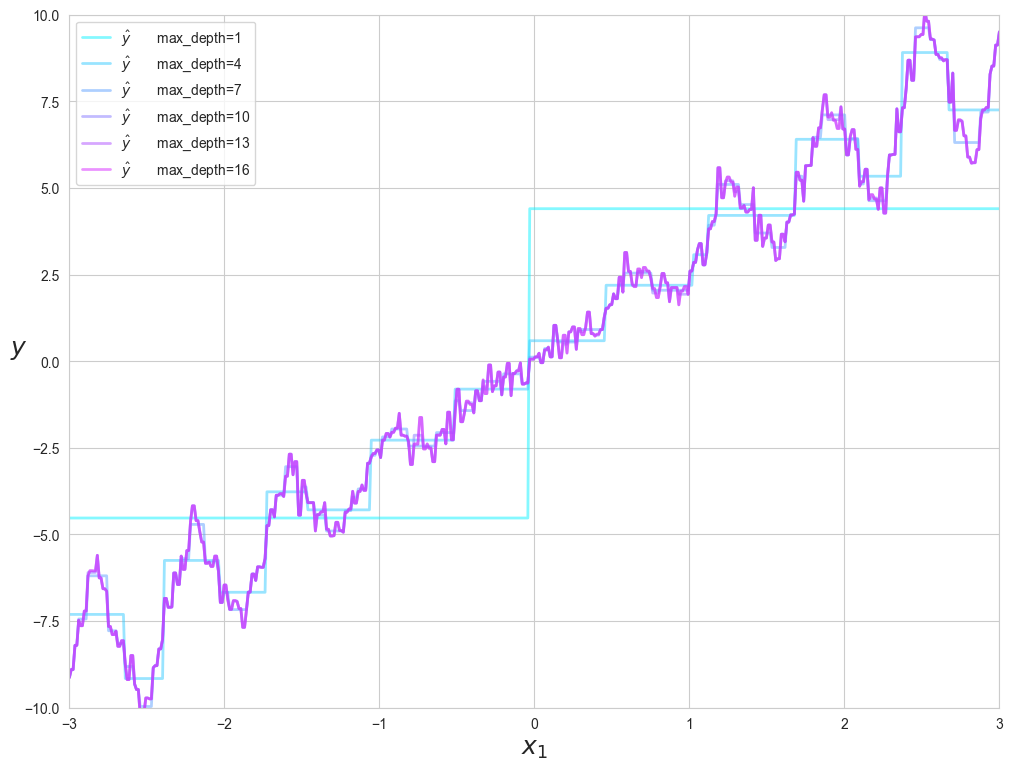

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
for i in range(1, 17, 3):
    tree_reg = DecisionTreeRegressor(max_depth=i)
    tree_reg.fit(X,y)
    plot_regression_predictions(tree_reg, X, y, i=i)

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

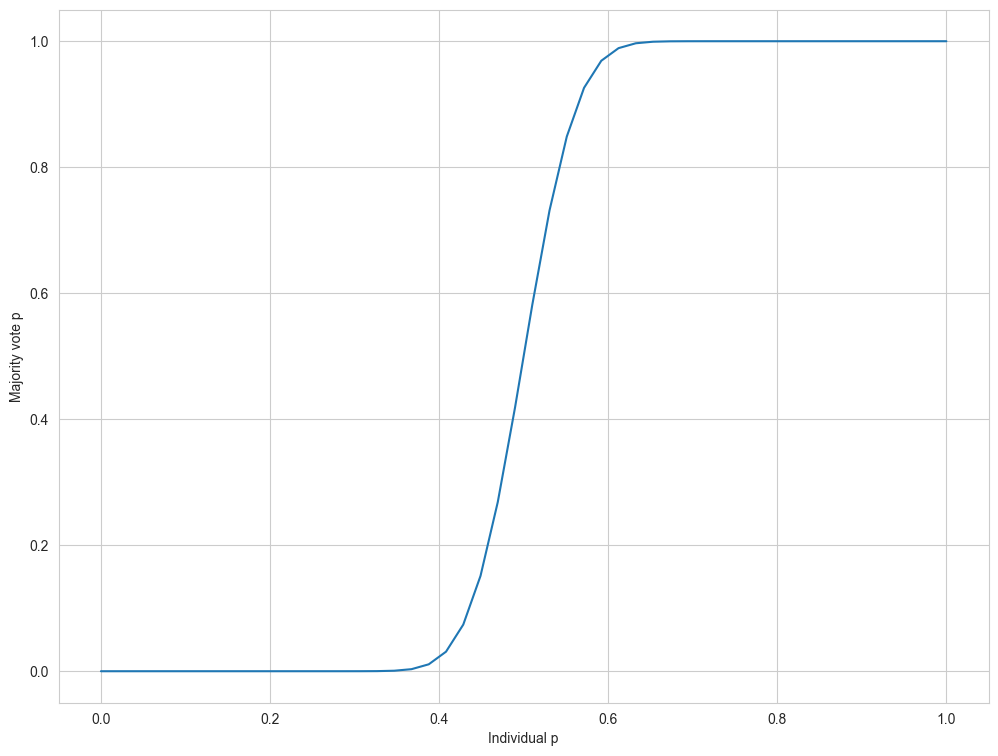

In [9]:
ps = np.linspace(0,1,50)
y = []
for p in ps:
    mu = 0
    for i in range(51,101+1):
        mu += (mt.factorial(101)/(mt.factorial(i)*mt.factorial(101-i))) * (p**i) * ((1.0 - p)**(101-i))
    y.append(mu)
    
plt.xlabel('Individual p')
plt.ylabel('Majority vote p')
plt.plot(ps,y);

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [10]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

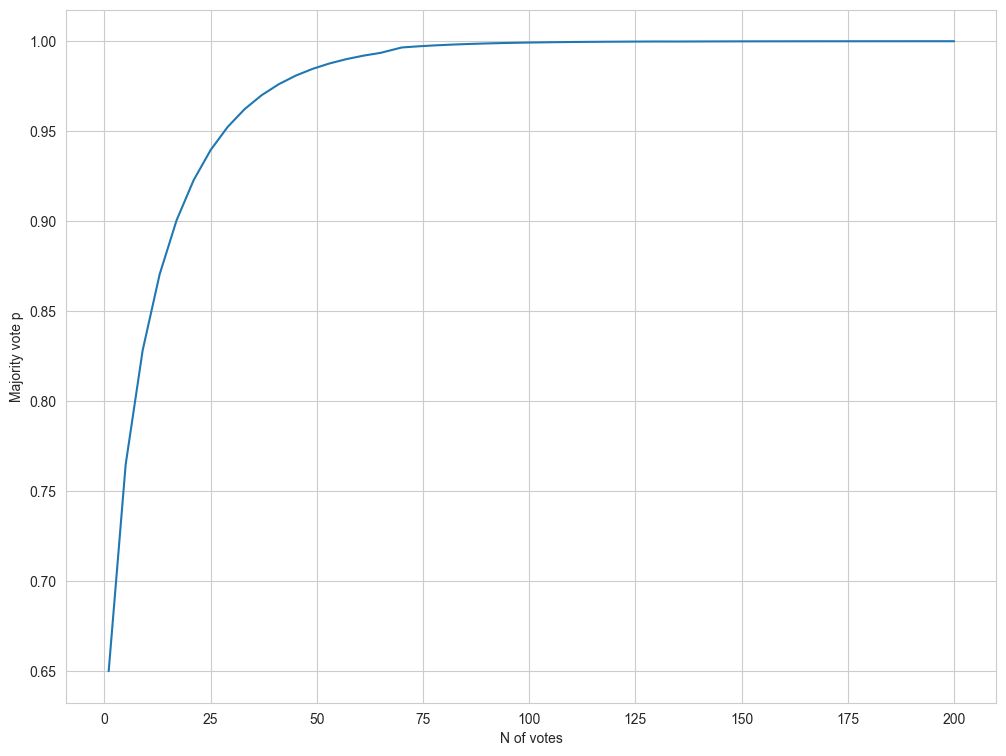

In [11]:
ns_cls = list(map(int, np.linspace(1,200,50)))
y = []
p = 0.65
for n_cls in ns_cls:
    mu = 0
    for i in range(n_cls//2 + n_cls%2,n_cls+1):
        mu += (mt.factorial(n_cls)/(mt.factorial(i)*mt.factorial(n_cls-i))) * (p**i) * ((1.0 - p)**(n_cls-i))
    y.append(mu)
    
plt.xlabel('N of votes')
plt.ylabel('Majority vote p')
plt.plot(ns_cls,y);

Опишите ваши наблюдения:

* Majority vote неплохо справляется в нашем случае - даже если IQ каждого классификатора 0.6, то все вместе справляются на ура
* Для получения хорошего результата, как мы видим, необходимо набрать хотя бы 100 голосов. В крайнем случае можно сэкономить, но минимум до 60

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [12]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(0, self.n_estimators):  
            np.random.seed(self.random_state + i)
            self.feat_ids_by_tree.append(np.random.choice(range(X.shape[1]), size=self.max_features, replace=False))

            pseudo_ids = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            pseudo_X = X[pseudo_ids, :][:, self.feat_ids_by_tree[i]]
            pseudo_y = y[pseudo_ids]

            dt_clf = DecisionTreeClassifier(max_depth=self.max_depth, 
                                           max_features=self.max_features,
                                           random_state=self.random_state + i) 
            dt_clf.fit(pseudo_X, pseudo_y)
            self.trees.append(dt_clf)
        return self

    def predict_proba(self, X):
         ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        proba = 0    
        for i, tree in enumerate(self.trees):         
            proba += tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
        return proba/self.n_estimators

    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [13]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

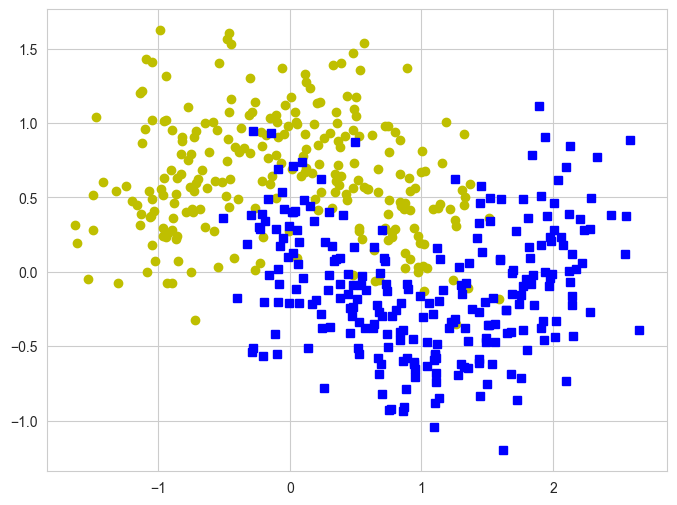

In [14]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

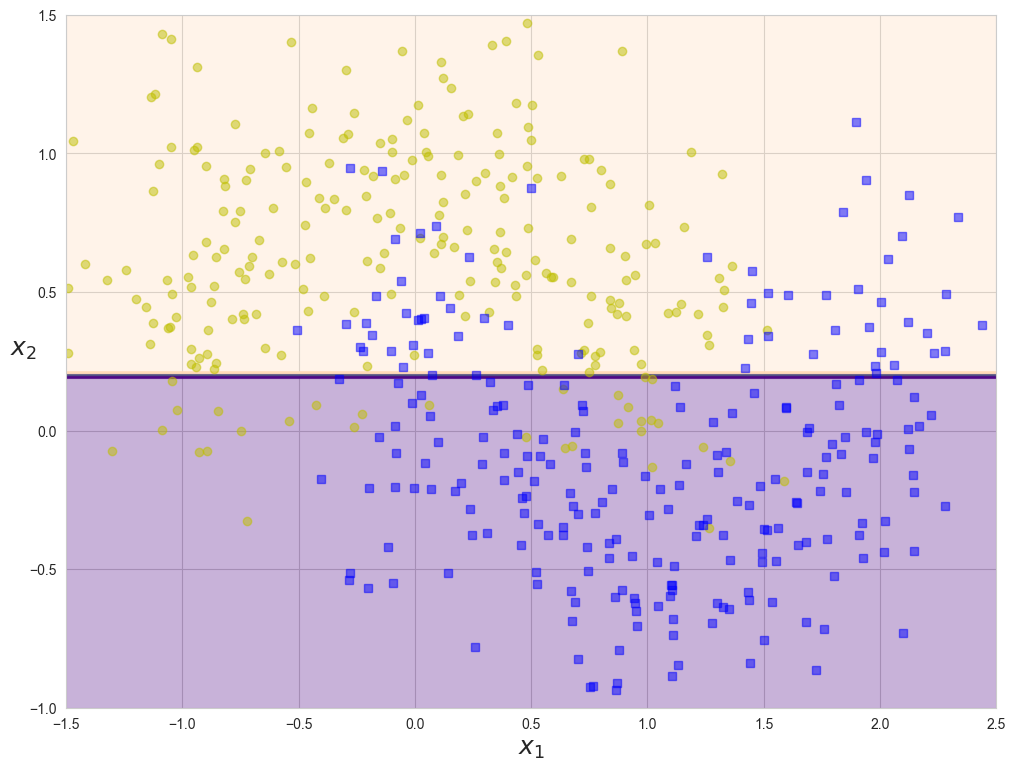

In [16]:
rf_cls = RandomForestClassifierCustom(max_depth=1, n_estimators=1000, max_features=2)
rf_cls.fit(X, y)
plot_decision_boundary(rf_cls, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

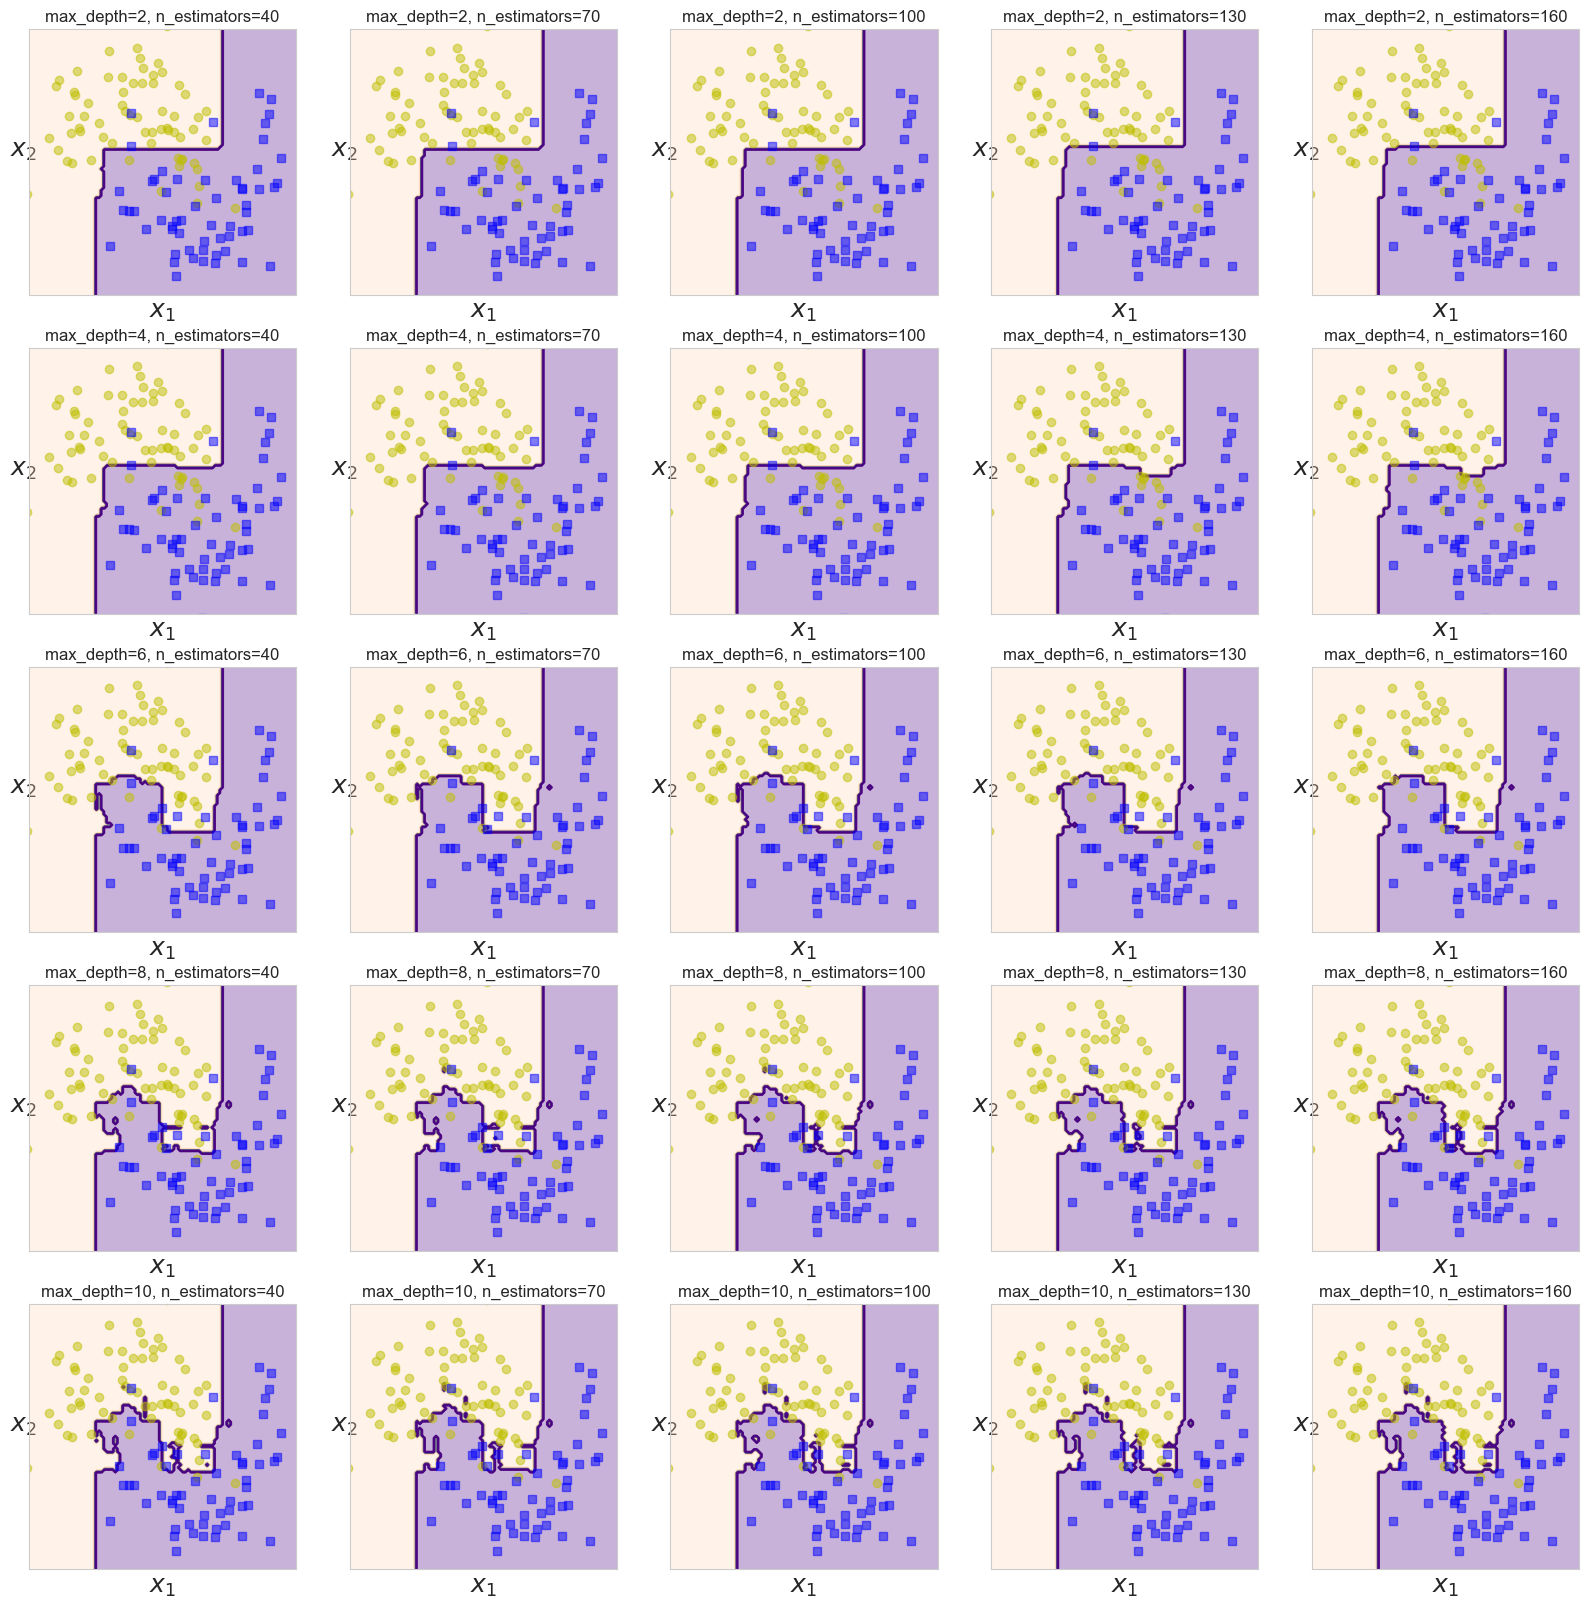

<Figure size 1000x1000 with 0 Axes>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(20, 20))
plot_ind = 1
for depth in range(2,11,2):
    for n_estim in range(40,161,30):
        clasif = RandomForestClassifierCustom(max_depth=depth, max_features=2, n_estimators=n_estim)
        clasif.fit(X_train,y_train)
        plt.subplot(5,5,plot_ind)
        plot_decision_boundary(clasif, X_test, y_test)
        plt.title(f'max_depth={depth}, n_estimators={n_estim}')
        plt.xticks([], [])
        plt.yticks([], [])
        plot_ind += 1

plt.figure(figsize=(10,10))
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [19]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [20]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [22]:
cor_res = []
max_features = [1, 2, 5, 10, 20, 50, 100]
for mf in max_features:
    rf_clf = RandomForestClassifier(max_features=mf)
    rf_clf.fit(X_train, y_train)
    cor_res.append(base_model_pair_correlation(rf_clf, X_test))

In [23]:
%R -i cor_res -i max_features

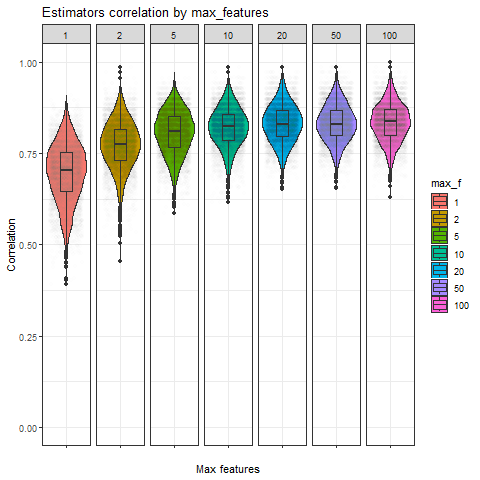

In [67]:
%%R 

library(tidyverse)

df = data.frame()
for(i in seq(1,7)){
    max_f_cors = cbind(cor_res[,i], max_features[i])
    df = rbind(df, max_f_cors)
}
names(df) = c('corrs', 'max_f')
df$max_f = as.factor(df$max_f)

ggplot(df, aes(y=corrs, x='', fill=max_f))+ geom_violin(width=1) + geom_boxplot(width=0.3)  + 
geom_jitter(alpha=0.004) + facet_grid( ~ max_f) + theme_bw() + ylim(0,1)+
ggtitle("Estimators correlation by max_features") + ylab('Correlation') + xlab('Max features')

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [73]:
cor_res = []
max_depths = [1, 2, 5, 10, 20, 100, 500]
for md in max_depths:
    rf_clf = RandomForestClassifier(max_depth=md)
    rf_clf.fit(X_train, y_train)
    cor_res.append(base_model_pair_correlation(rf_clf, X_test))

In [74]:
%R -i cor_res -i max_depths

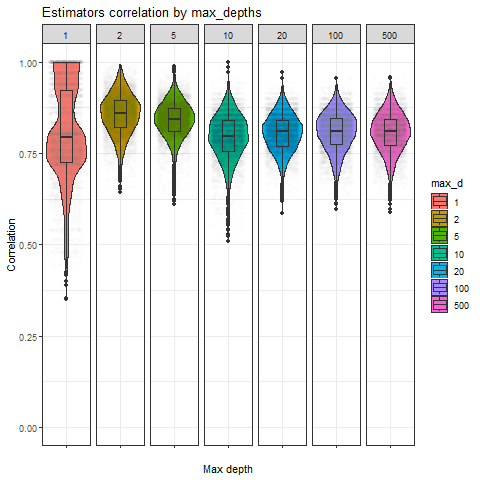

In [75]:
%%R 

library(tidyverse)

df = data.frame()
for(i in seq(1,7)){
    max_f_cors = cbind(cor_res[,i], max_depths[i])
    df = rbind(df, max_f_cors)
}
names(df) = c('corrs', 'max_d')
df$max_d = as.factor(df$max_d)

ggplot(df, aes(y=corrs, x='', fill=max_d))+ geom_violin(width=1) + geom_boxplot(width=0.3)  + 
geom_jitter(alpha=0.004) + facet_grid( ~ max_d) + theme_bw() + ylim(0,1)+
ggtitle("Estimators correlation by max_depths") + ylab('Correlation') + xlab('Max depth')

Опишите ваши наблюдения:

* Чем больше параметр `max_features`, тем сильнее корреляция эстиматоров, но при слишком больших значениях выходит на некоторое плато около 0.8
* При варьировании `max_depths` также выходим на аналогичное плато, однако при маленьких значениях корреляция может быть выше, а при значении 1 вообще поведение становится менее предсказуемым.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [85]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

C:\Users\vauli\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [86]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [102]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
#cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [103]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')


## END YOUR CODE HERE ##

for model in [dt, rf, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8379629629629629
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LGBMCla

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [99]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [100]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [108]:
for model in [dt, rf, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]:
    model.fit(X_train, y_train)

voting_soft_cls = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft_cls.fit(X_train, y_train)
solf_voting_correlations = base_model_pair_correlation_for_voting_clf(voting_soft_cls, X)

Какие модели чаще всего с кем нибудь скореллирваны?

In [153]:
solf_voting_correlations = pd.DataFrame(solf_voting_correlations, columns=['Model 1', 'Model 2', 'Corr'])
models = solf_voting_correlations.sort_values('Corr', ascending=False).head(10)[['Model 1', 'Model 2']].stack().reset_index()
models[0].map(lambda x: str(x).split('(')[0]).value_counts()

LGBMClassifier            4
XGBClassifier             4
RandomForestClassifier    4
ExtraTreesClassifier      3
XGBRFClassifier           3
SVC                       1
LogisticRegression        1
Name: 0, dtype: int64

Попробовал повыкидывать вручную, но быстро понял что гиблое дело. 
Я поставил на ночь кучу циклов на подборы параметров моделей и suffle моделей, всего провел около 25000 голосований натренировав суммарно более 100 000 моделей. Суммарно гналось более 6 часов пока я спал. Вот тут оставил чанк где у меня идет полный перебор всех комбинаций всех моделек кроме CatBoost. Ниже обсудим результаты. Каждая черточка это одна модель (я следил чтобы машина работала). 

In [440]:
%%time 

good_res = []
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=100, n_jobs=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, )
rf = RandomForestClassifier(n_estimators=15,  max_depth=3, 
                            min_samples_leaf=5, random_state=SEED, n_jobs=-1)
etc = ExtraTreesClassifier(random_state=SEED, n_estimators=15, 
                           max_depth=15, n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance" , 
                           metric='chebyshev', n_jobs=-1)

all_estimators =  [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("LGBM", lgbm), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

elections = 0
models_trained = 0

all_estimators_ids = list(range(0, len(all_estimators)))
for n in [2, 3, 4, 5, 6, 7]:
    all_combinations_of_n_size = list(itertools.combinations(all_estimators_ids,n))
    for comb in all_combinations_of_n_size:
        estimators = [all_estimators[id_] for id_ in comb]
        for voting in ['soft', 'hard']:
            voting_soft_cls = VotingClassifier(estimators=estimators, voting = voting, n_jobs=-1)
            voting_soft_cls.fit(X_train, y_train)
            scores = cross_val_score(voting_soft_cls, X_train, y_train, cv=3, scoring="f1");
            elections += 1
            models_trained += n
            if scores.mean() >= 0.89:
                print('\n')
                print(f" |{voting=} of {comb}:\t {round(scores.mean(), 5)}{flag} |")
                good_res.append((scores.mean(), comb, voting))
            elif scores.mean() > 0.874:
                good_res.append((scores.mean(), comb, voting))
                print('=', end='')               
            else:
                print('-', end='')

print(f'{elections=}')
print(f'{models_trained=}')

--------------------------------------------------------------------------------------------------------------------------------------------------------------------=-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Вот 6-часовой рассчет который я прервал потому что началась лекция по машинке:

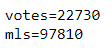

В целом нашел пару неплохих комбинаций:

In [454]:
print(good_res)
for model in good_res:
    estimators = [all_estimators[id_] for id_ in model[1]]
    print(estimators)

[(0.8744708994708995, (0, 4, 8), 'soft'), (0.8744708994708995, (0, 1, 2, 4, 9), 'soft')]
[('DT', DecisionTreeClassifier(max_depth=3, min_samples_leaf=15, random_state=111)), ('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)), ('XGB_RF', XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_s

Проверим эти две модельки еще разок отдельно

In [534]:
models_set =  [("DT", dt), ("SVC_LIN", svc_lin), ("XGB_RF", xgb_rf)]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting = voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)
    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1");

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'===== {voting=} =====')
    print(f'sklearn {f1=}')
    print(f'{scores=}, {scores.mean()=}\n')

===== voting='soft' =====
sklearn f1=0.8823529411764706
scores=array([0.925     , 0.88888889, 0.80952381]), scores.mean()=0.8744708994708995

===== voting='hard' =====
sklearn f1=0.8653846153846154
scores=array([0.86075949, 0.83544304, 0.80952381]), scores.mean()=0.8352421137231264



In [535]:
models_set = [("DT", dt), ("RF", rf),  ("ETC", etc), ("SVC_LIN", svc_lin),("LR", lr)]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting = voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)
    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1");

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'===== {voting=} =====')
    print(f'sklearn {f1=}')
    print(f'{scores=}, {scores.mean()=}\n')

===== voting='soft' =====
sklearn f1=0.8737864077669905
scores=array([0.925     , 0.88888889, 0.80952381]), scores.mean()=0.8744708994708995

===== voting='hard' =====
sklearn f1=0.8823529411764706
scores=array([0.8974359 , 0.83544304, 0.79069767]), scores.mean()=0.8411922032763952



Меня немного смутило соседство решающего дерева и случайеного леса, решил убрать первое. В итоге нашел модель, которая на `sklearn` метрике `f1` показывает результат **`лучше 0.89`**. Но на кросс-валидационной проверке - все еще нет.

In [536]:
models_set = [("RF", rf),  ("ETC", etc), ("SVC_LIN", svc_lin),("LR", lr)]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting = voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)
    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1");

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'===== {voting=} =====')
    print(f'sklearn {f1=}')
    print(f'{scores=}, {scores.mean()=}\n')

===== voting='soft' =====
sklearn f1=0.8910891089108911
scores=array([0.91358025, 0.825     , 0.8045977 ]), scores.mean()=0.8477259826876685

===== voting='hard' =====
sklearn f1=0.8888888888888888
scores=array([0.86842105, 0.82051282, 0.81927711]), scores.mean()=0.8360703271927115



Ниже: Некоторые комбинации даже еще лучше работают на `f1-score`, но хуже работают на кросс-валидации

In [562]:
all_estimators =  [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("LGBM", lgbm), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

models_set = [("ETC", etc), ("NB", nb), ]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting = voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)
    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1");

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'===== {voting=} =====')
    print(f'sklearn {f1=}')
    print(f'{scores=}, {scores.mean()=}\n')

===== voting='soft' =====
sklearn f1=0.9166666666666666
scores=array([0.87179487, 0.81012658, 0.8045977 ]), scores.mean()=0.8288397184075927

===== voting='hard' =====
sklearn f1=0.9052631578947369
scores=array([0.86111111, 0.70422535, 0.75609756]), scores.mean()=0.773811341399799



Мне даже интересно какая комбинация моделей работает хорошо. Может, я где-то накосячил с генерацией комбинаторных объектов. Иначе не знаю почему у меня ее нет. В любом случае могу сказать несколько соображений. 
- Не хочется ожидать видеть в лучшем ансамбле модели с сильной корреляцией
- Не хочется ожидать видеть в лучшем ансамбле модели с похожей идеологией работы.

Как крайний пример второго пункта, я бы точно был удивлен увидеть решающее дерево вместе со случайным лесом в одном голосовании. Наверное, я бы DT вообще убрал из рассмотрения при наличии  RF.

Ну и плюс может быть до заветного результата мне не хватило CatBoost. Его обещали подкрутить еще в декабре 2022 года, но issue  на github все так и висит, так и висит. 

У меня в итоге лучшие комбинации:
    
1. DT + SVC_LIN + XGB_RF
2. RF + ETC + SVC_LIN + LR 
3. ETC + NB 


# Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [232]:
telecom = pd.read_csv("churn.csv")
telecom.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [233]:
print(telecom.shape)
print(f'Всего имеется {len(telecom)} наблюдений\n')
telecom.info()

(3333, 21)
Всего имеется 3333 наблюдений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   floa

`NA` не видно. 

Уберем спец.символы:

In [235]:
telecom=telecom.rename(columns={"Churn?":"Churn", "Int'l Plan":"Intl Plan"})

> ### Поработаем над переменными:

Сперва посмотрим на целевую переменную. Дисбалланс на лицо... Но больше конечно удивляют точки в конце булевых переменных. Автор, все ок?

In [236]:
print(telecom.Churn.value_counts())
telecom.Churn.replace({'False.': 0, 'True.': 1}, inplace=True)

False.    2850
True.      483
Name: Churn, dtype: int64


**Поехали по фичам**

`State` - нужен или нет?  Сложно понять, но может модель там что и выудит, оставлю.

In [237]:
pd.crosstab(telecom.Churn, telecom.State, margins=True)

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,All
Churn,,,,,,,,,,,,,,,,,,,,,
0,49,72,44,60,25,57,62,49,52,55,...,48,54,62,72,65,52,71,96,68,2850
1,3,8,11,4,9,9,12,5,9,8,...,5,18,10,5,8,14,7,10,9,483
All,52,80,55,64,34,66,74,54,61,63,...,53,72,72,77,73,66,78,106,77,3333


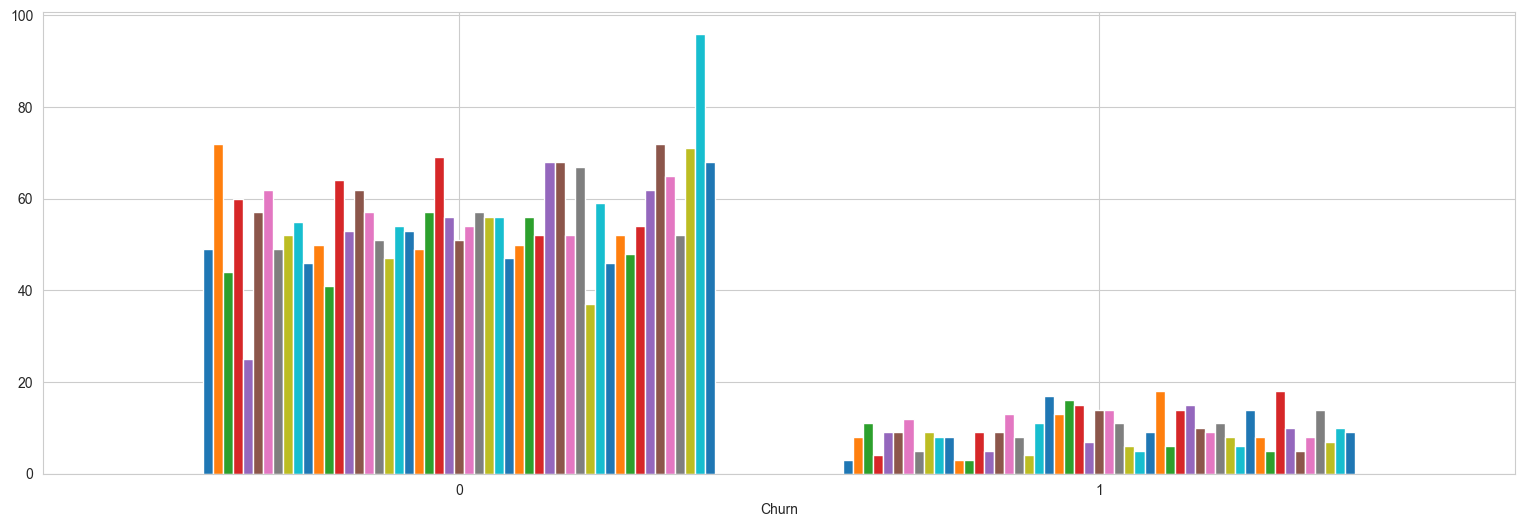

In [238]:
plt.rcParams["figure.figsize"] = 19, 6
ct = pd.crosstab(telecom.Churn, telecom.State)
ct.plot.bar(rot=0, width=0.8)
plt.legend().remove()

415    1655
510     840
408     838
Name: Area Code, dtype: int64

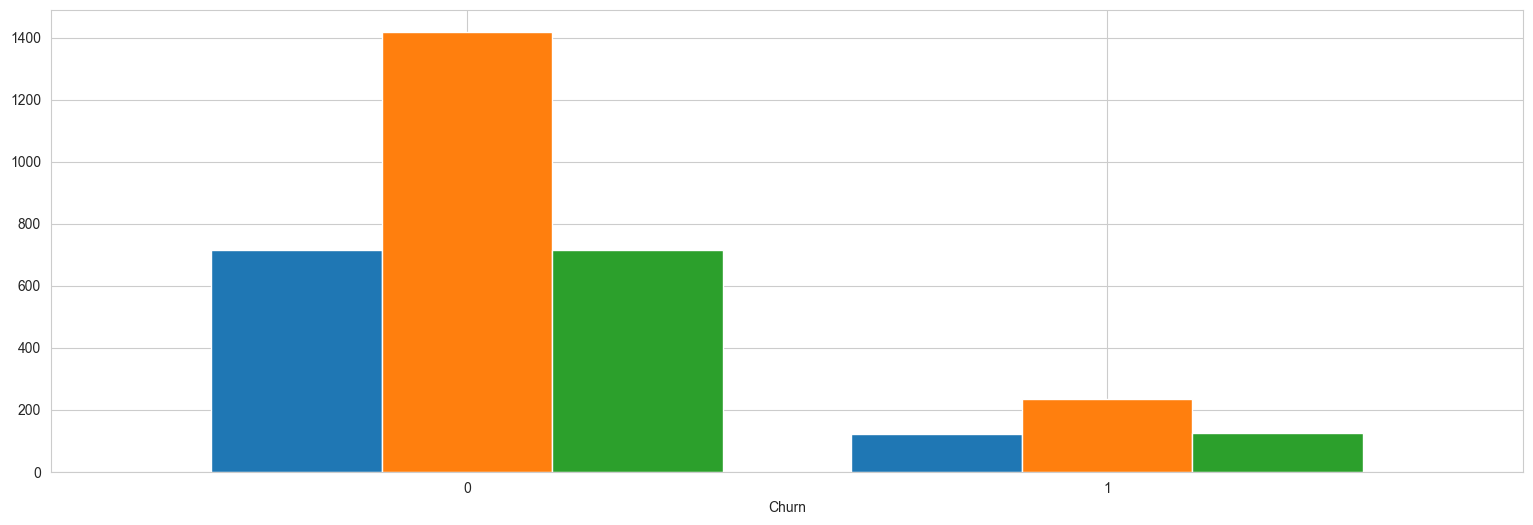

In [239]:
plt.rcParams["figure.figsize"] = 19, 6
ct = pd.crosstab(telecom.Churn, telecom['Area Code'])
ct.plot.bar(rot=0, width=0.8)
plt.legend().remove()
telecom['Area Code'].value_counts()

<AxesSubplot: >

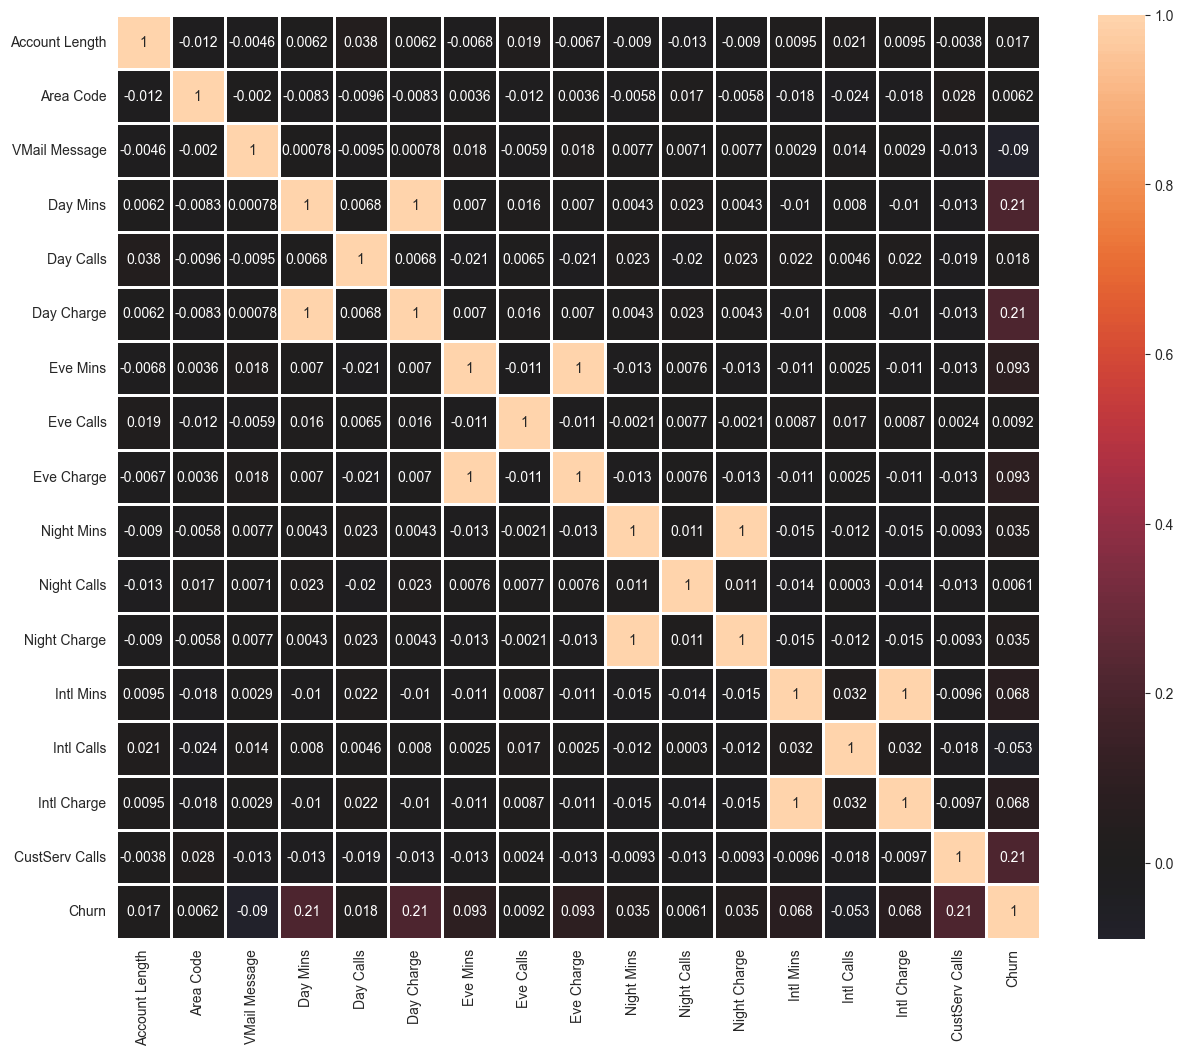

In [240]:
plt.rcParams["figure.figsize"] = 15, 12
corr = telecom.corr()
sns.heatmap(corr,center=0, square=True, linewidths=.9, annot=True)

В общем посмотрев на все это дело пришел к такому решению:
- телефон выбросил  потому что по сути это ID юзера
- код площади выбросил потому что там всего три кода и не особо было связано с чурном
- Штат решил оставить, надо будет на OHE-шить

In [241]:
features_to_drop = ['Phone', 'Area Code', 'Day Charge', 'Eve Charge', 'Night Charge','Intl Charge']
cat_features = ['State']
bool_features = [ 'Intl Plan', 'VMail Plan']
num_features = ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 
                'Eve Mins', 'Eve Calls',  'Night Mins', 'Night Calls', 
                'Intl Mins', 'Intl Calls', 'CustServ Calls']

In [242]:
telecom_clean = telecom.drop(features_to_drop, axis = 1)

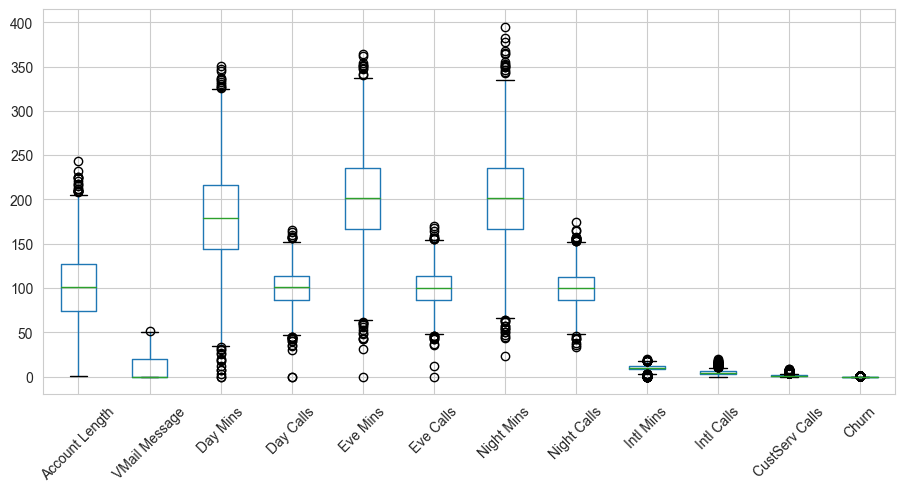

In [243]:
plt.rcParams["figure.figsize"] = 11, 5
telecom_clean.boxplot()
plt.xticks(rotation=45);

<AxesSubplot: >

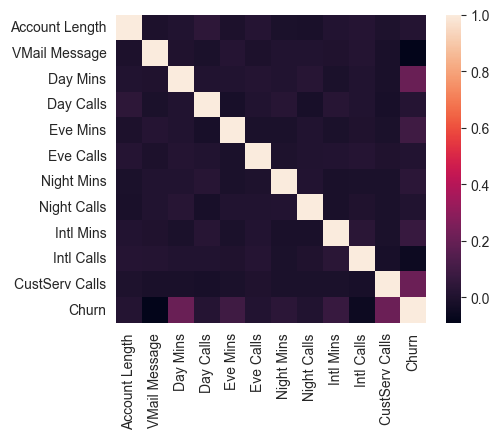

In [244]:
plt.rcParams["figure.figsize"] =  5,4
corr = telecom_clean.corr()
sns.heatmap(corr)

> Погнали

In [245]:
X = telecom_clean.drop(['Churn'], axis=1)
y = telecom_clean[['Churn']]

prepoccessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

Посмотрим на дефолтные модели:

Ну сами по себе они уже неплохо работают... хотя мы то знаем в чем дело:

In [246]:
def build_default_models(models, prepoccessor, X_train, X_test, y_train, y_test):
    fig, axes = plt.subplots(1, 2);
    for i, model in enumerate(models):
        pipe = make_pipeline(prepoccessor, model)
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)
        y_pred_prob = pipe.predict_proba(X_test)
        print(f'Accuracy of {str(model).split("(")[0]} = {round(accuracy_score(y_test, y_pred), 3)}')
        
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(ax = axes[i])

Accuracy of LGBMClassifier = 0.928
Accuracy of XGBRFClassifier = 0.919


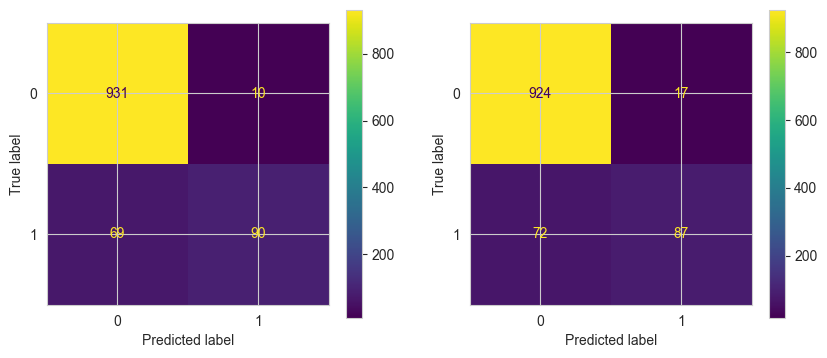

In [248]:
plt.rcParams["figure.figsize"] = 10,4
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
xgbrf = xgboost.XGBRFClassifier(random_state=SEED)
build_default_models([lgbm, xgbrf], prepoccessor, X_train, X_test, y_train, y_test)

Поподбираем параметры для XGBRF

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Account Length',
                                                   'VMail Message', 'Day Mins',
                                                   'Day Calls', 'Eve Mins',
                                                   'Eve Calls', 'Night Mins',
                                                   'Night Calls', 'Intl Mins',
                                                   'Intl Calls',
                                                   'CustServ Calls']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['State'])])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.17333333333333334, max_depth=50,
                                objective='binary', random_state=111,
                                reg_alpha

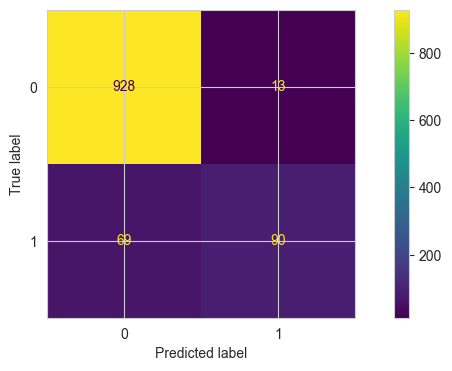

In [250]:
X = telecom_clean.drop(['Churn'], axis=1)
y = telecom_clean[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
xgbrf = xgbrf = xgboost.XGBRFClassifier(random_state=SEED, n_jobs=-1)
xgbrf_pipe = make_pipeline(prepoccessor, xgbrf)

lgbm_grid = {
    'lgbmclassifier__max_depth': [1, 5,  50, -1],
    'lgbmclassifier__n_estimators':[1, 10 , 100],
    'lgbmclassifier__learning_rate': np.linspace(0.01,0.5,4),
    'lgbmclassifier__num_leaves': range(31, 200, 40),
    'lgbmclassifier__reg_alpha': [0, 0.2, 1],
    'lgbmclassifier__reg_lambda': [0, 0.2, 1],
    }

gs_xgbrf_pipe = GridSearchCV(lgbm_pipe, param_grid=lgbm_grid, cv=cv)
gs_xgbrf_pipe.fit(X_train, y_train)
print(gs_xgbrf_pipe.best_estimator_)
y_pred = gs_xgbrf_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

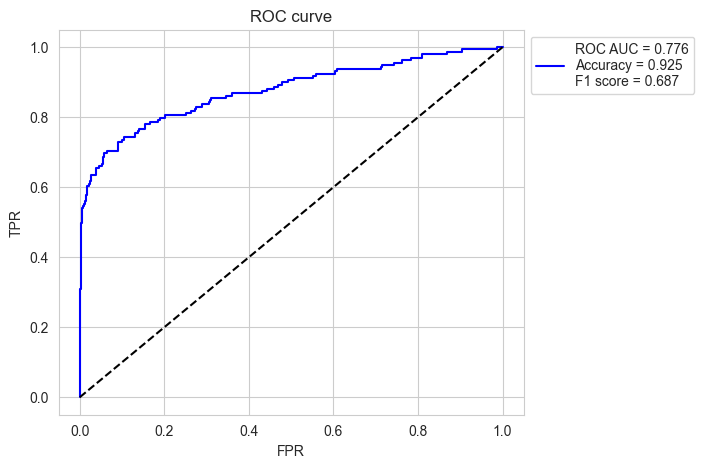

In [251]:
def custom_roc(y_test, y_pred_prob, y_pred):
    plt.rcParams["figure.figsize"] = 6, 5
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc_text = f'ROC AUC = {round(roc_auc_score(y_test, y_pred), 3)}'
    accuracy_text =  f'Accuracy = {round(accuracy_score(y_test, y_pred), 3)}'
    f1_text =  f'F1 score = {round(f1_score(y_test, y_pred), 3)}'
    legend =  roc_auc_text + '\n' + accuracy_text + '\n' + f1_text
    plt.step(fpr, tpr, color='b', label = legend)
    plt.plot(np.linspace(0,1,2), color = 'k', linestyle="--")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC curve')
    plt.legend(bbox_to_anchor =(1,1))
    plt.show()
    
y_pred_prob = gs_xgbrf_pipe.predict_proba(X_test)    
custom_roc(y_test, y_pred_prob, y_pred)

Что получили с XGBRF? Ну, результаты так себе... Кажется проблема в дисбалансе классов

Попробуем разные методы борьбы с дисбалансом:

In [252]:
telecom_clean.Churn.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

1. **Downgrade**

0    483
1    483
Name: Churn, dtype: int64
Accuracy of LGBMClassifier = 0.746
Accuracy of XGBRFClassifier = 0.777


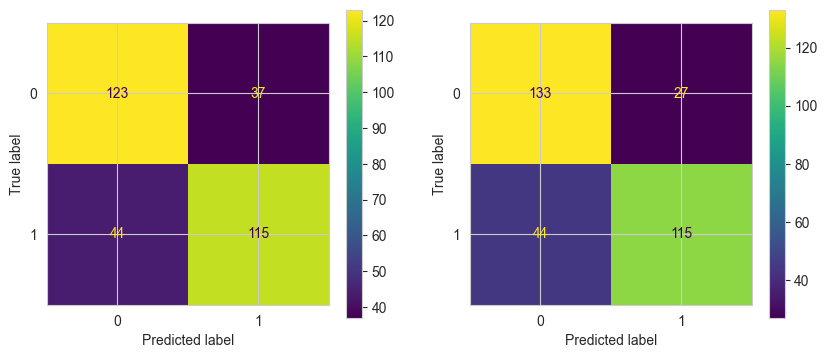

In [260]:
plt.rcParams["figure.figsize"] = 10,4
telecom_down = telecom_clean.query('Churn==0').sample(n=483, random_state=SEED).append(telecom_clean.query('Churn==1'))
print(telecom_down.Churn.value_counts())

X = telecom_down.drop(['Churn'], axis=1)
y = telecom_down[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)
build_default_models([lgbm, xgbrf], prepoccessor, X_train, X_test, y_train, y_test)

Ну, метрики не оч, но мы начали предсказывать оба лейбла

2. **Upgrade**

1    2850
0    2850
Name: Churn, dtype: int64
Accuracy of LGBMClassifier = 0.967
Accuracy of XGBRFClassifier = 0.875


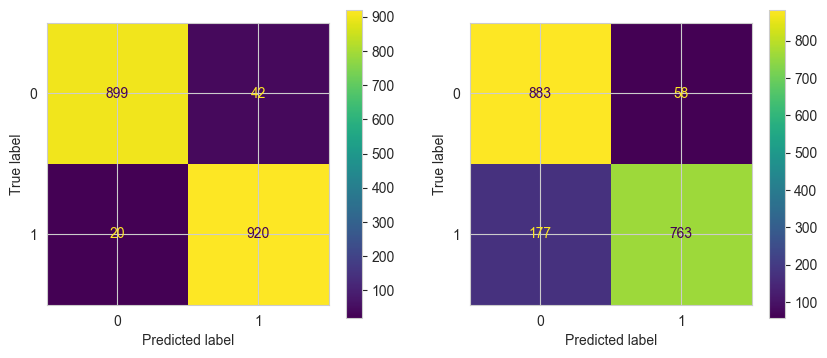

In [261]:
plt.rcParams["figure.figsize"] = 10,4
telecom_up = telecom_clean.query('Churn==1').sample(n=2850, replace=True).append(telecom_clean.query('Churn==0'))
print(telecom_up.Churn.value_counts())

X = telecom_up.drop(['Churn'], axis=1)
y = telecom_up[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)
build_default_models([lgbm, xgbrf], prepoccessor, X_train, X_test, y_train, y_test)

Ну вот, левая моделька совсем хорошо смотрится. А на исходных данных она норм предскажет?

Accuracy of LGBMClassifier = 0.958


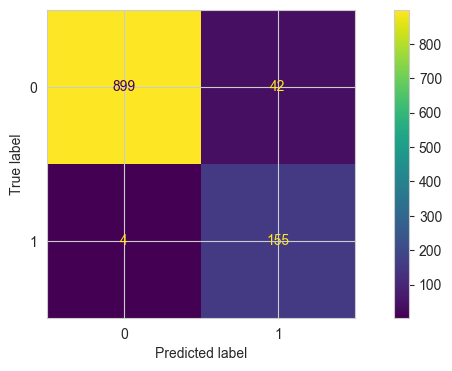

In [262]:
# Делаем Upgrade данные
X = telecom_up.drop(['Churn'], axis=1)
y = telecom_up[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

# Тренируемся на них
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
pipe = make_pipeline(prepoccessor, lgbm)
pipe.fit(X_train, y_train)

# Берем исходный тест
X = telecom_clean.drop(['Churn'], axis=1)
y = telecom_clean[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

# Проверяем
y_pred = pipe.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)
print(f'Accuracy of {str(lgbm).split("(")[0]} = {round(accuracy_score(y_test, y_pred), 3)}')
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Ну это сильно лучше чем было - 155 в правом нижнем углу ( а было 90!). 

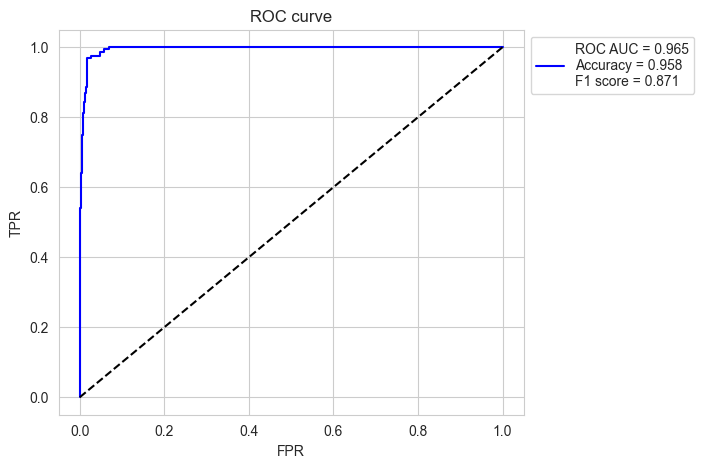

In [263]:
custom_roc(y_test, y_pred_prob, y_pred)

Попробуем по-подбирать параметры для LGBMC держа в уме что мы решили проблемы с балансом

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Account Length',
                                                   'VMail Message', 'Day Mins',
                                                   'Day Calls', 'Eve Mins',
                                                   'Eve Calls', 'Night Mins',
                                                   'Night Calls', 'Intl Mins',
                                                   'Intl Calls',
                                                   'CustServ Calls']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['State'])])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.1325, max_depth=50,
                                num_leaves=71, objective='binary',
                                random_state=111, reg_alp

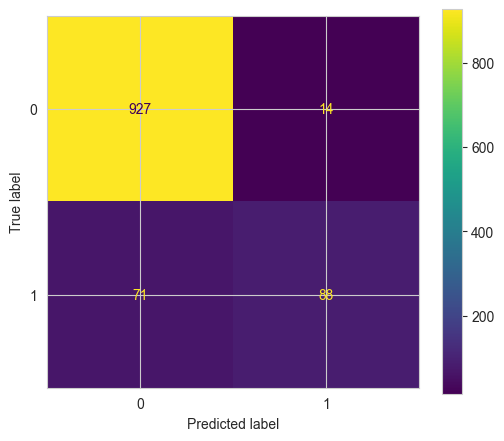

In [265]:
X = telecom_clean.drop(['Churn'], axis=1)
y = telecom_clean[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, objective='binary', n_jobs=-1)
lgbm_pipe = make_pipeline(prepoccessor, lgbm)

lgbm_grid = {
    'lgbmclassifier__max_depth': [1, 5,  50, -1],
    'lgbmclassifier__n_estimators':[1, 10 ,100],
    'lgbmclassifier__learning_rate': np.linspace(0.01,0.5,5),
    'lgbmclassifier__num_leaves': range(31, 200, 40),
    'lgbmclassifier__reg_alpha': [0, 0.2, 1],
    'lgbmclassifier__reg_lambda': [0, 0.2, 1],
    }

gs_lgbm_pipe = GridSearchCV(lgbm_pipe, param_grid=lgbm_grid, cv=cv)
gs_lgbm_pipe.fit(X_train, y_train)
print(gs_lgbm_pipe.best_estimator_)
y_pred = gs_lgbm_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Ну, здесь надо понимать - это данные с дисбалансом. Посмотрим как он сработает на upgrade данных:

Accuracy of LGBMClassifier = 0.966


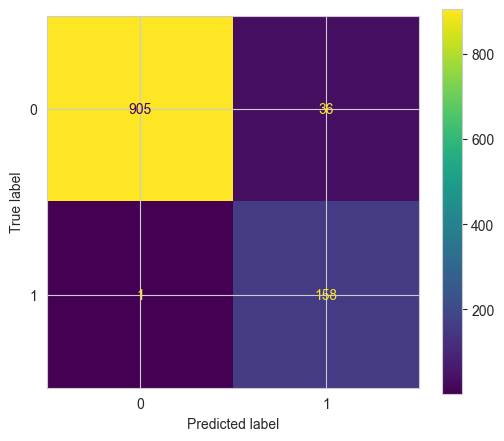

In [266]:
# Делаем Upgrade данные
X = telecom_up.drop(['Churn'], axis=1)
y = telecom_up[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

# Тренируемся на них
gs_lgbm_pipe.best_estimator_.fit(X_train, y_train)

# Берем исходный тест
X = telecom_clean.drop(['Churn'], axis=1)
y = telecom_clean[['Churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

# Проверяем
y_pred = gs_lgbm_pipe.best_estimator_.predict(X_test)
y_pred_prob = gs_lgbm_pipe.best_estimator_.predict_proba(X_test)
print(f'Accuracy of {str(lgbm).split("(")[0]} = {round(accuracy_score(y_test, y_pred), 3)}')
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Стало еще лучше:)

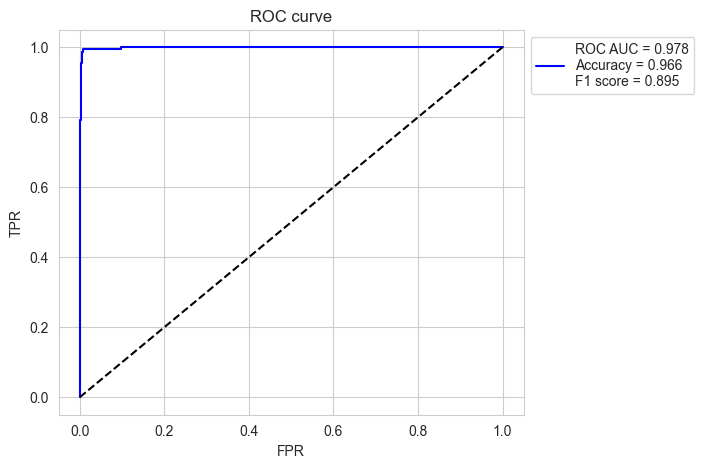

In [267]:
custom_roc(y_test, y_pred_prob, y_pred)

Вывод - вообще здорово вышло. Выбрал 2 модели, `LGBMClassifier` и `XGBRFClassifier`. Первая показала себя лучше в базовом варианте и я углубился с ней в попытки решить проблему балланса классов. В итоге вышло очень хорошо. 

Грустно что не погонял `CatBoost` - когда то я с ним работал и он мне хорошие результаты давал, но его пока что нет на питоне 3.11 (да, он мог бы просто создать новый кернел или окружение). Надеюсь с дедлайну по доте разрабочики `CatBoost` его дофиксят. 

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

`Catboost`, вид сзади:

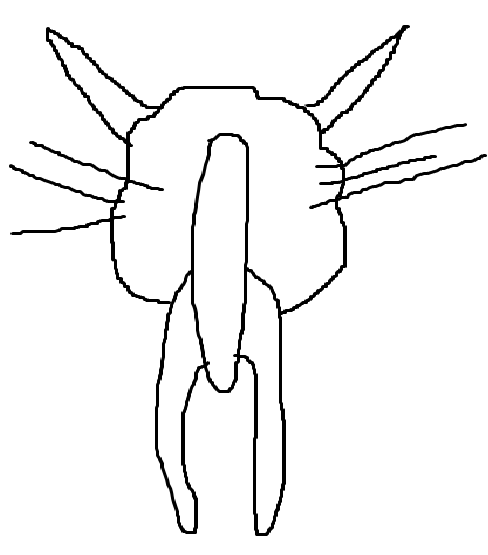

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**